### Glutamate release data preparation

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import seaborn as sns

This notebook explains how the glutamate traces (saved in `120_center_responses.pkl`) are selected for training. The first part of the selection happens in the `organize_data` function in `data_prep.py` which converts the downloaded file `Data_Cones.h5` to the file `cone_data_uncentered.pkl`. This function filters out nan traces, low quality trials, and divides the traces by scan location. More information is also extracted including the appoximate (x, y) location of the ROIs and the approximate location of the scan field. This information, however, is not used for our training of the ribbon synapse, only in so far as selecting 60 glutamate recordings from the dorsal retina and 60 from the ventral retina. 

In [ ]:
data_path = "../../data/cone_data_uncentered.pkl"

with open(data_path, 'rb') as f:
    data = pickle.load(f)

# Gather all traces and divide into ventral and dorsal traces (see data_prep.choose_traces)
all_cs_traces = [data[i]["cs_glut"].T for i in range(len(data))]
sf_locs = np.array([data[i]["scan_loc"][1] for i in range(len(data))])
dorsal_traces = np.vstack([all_cs_traces[i] for i in np.where(sf_locs > 0)[0]])
ventral_traces = np.vstack([all_cs_traces[i] for i in np.where(sf_locs < 0)[0]])
fs = 1 / 500

In [69]:
# Divide the dorsal traces into center and surround for each color
green_center_dorsal = dorsal_traces[:, 0:int(2/fs)]
uv_center_dorsal = dorsal_traces[:, int(4/fs):int(6/fs)]

green_surround_dorsal = dorsal_traces[:, int(2/fs):int(4/fs)]
uv_surround_dorsal = dorsal_traces[:, int(6/fs):int(8/fs)]

In [70]:
# Divide the ventral traces into center and surround for each color
green_center_ventral = ventral_traces[:, 0:int(2/fs)]
uv_center_ventral = ventral_traces[:, int(4/fs):int(6/fs)]

green_surround_ventral = ventral_traces[:, int(2/fs):int(4/fs)]
uv_surround_ventral = ventral_traces[:, int(6/fs):int(8/fs)]

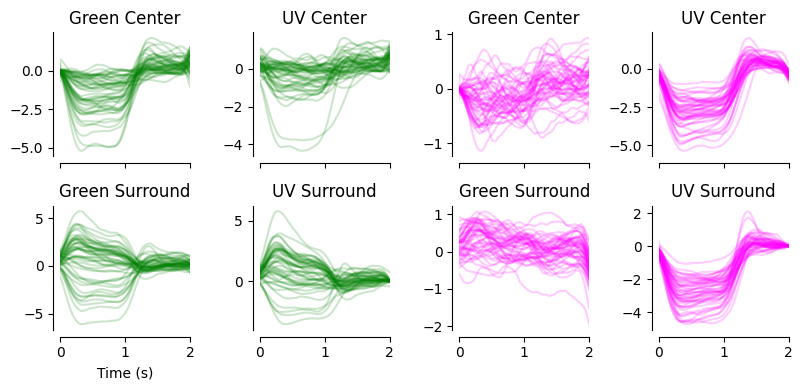

In [78]:
# Plot some of the center traces
fig, ax = plt.subplots(2, 4, figsize=(8, 4), sharex=True)

time = np.arange(0, 2, step=fs)

for i in range(50):
    ax[0, 0].plot(time, green_center_dorsal[i, :], color="g", alpha=0.2)
    ax[0, 1].plot(time, uv_center_dorsal[i, :], color="g", alpha=0.2)

    ax[1, 0].plot(time, green_surround_dorsal[i, :], color="g", alpha=0.2)
    ax[1, 1].plot(time, uv_surround_dorsal[i, :], color="g", alpha=0.2)

ax[0, 0].set_title("Green Center")
ax[0, 1].set_title("UV Center")
ax[1, 0].set_title("Green Surround")
ax[1, 1].set_title("UV Surround")

for i in range(50):
    ax[0, 2].plot(time, green_center_ventral[i, :], color="magenta", alpha=0.2)
    ax[0, 3].plot(time, uv_center_ventral[i, :], color="magenta", alpha=0.2)

    ax[1, 2].plot(time, green_surround_ventral[i, :], color="magenta", alpha=0.2)
    ax[1, 3].plot(time, uv_surround_ventral[i, :], color="magenta", alpha=0.2)

ax[0, 2].set_title("Green Center")
ax[0, 3].set_title("UV Center")
ax[1, 2].set_title("Green Surround")
ax[1, 3].set_title("UV Surround")

ax[0, 0].set_xlim(0, 2)
ax[1, 0].set_xlabel("Time (s)")

sns.despine(offset=5)
plt.tight_layout()
plt.show()

The traces were then filtered into cases where the surround doesn't hyperpolarize, and the original reason was likely because individual photoreceptors (without the input from neighboring photoreceptors), would not have a mechanism to hyperpolarize to the surround. However, the isolated photoreceptors shouldn't be expected to respond to the surround stimulus at all, so this filtering was in the end irrelevant. This is then why only the center segments are used to train the ribbon synapse model of the isolated photoreceptors.

In [ ]:
# Filter the data into traces where the surround doesn't hyperpolarize, because the indiv. 
inds = []
for traces in (dorsal_traces, ventral_traces):
    segments = [traces[:, int(i / fs) : int((i + 2) / fs)] for i in range(0, 8, 2)]
    means = [np.mean(segment, axis=1) for segment in segments]

    green_surround_pos = np.where(means[1] > 0.25)[0]
    green_center_neg = np.where(means[0] < 0.0)[0]
    uv_center_neg = np.where(means[2] < 0.0)[0]

    center_neg = np.intersect1d(green_center_neg, uv_center_neg)
    inds.append(np.intersect1d(green_surround_pos, center_neg))

`trace_collection` is the output of the `choose_traces` function from `data_prep.py`. This function would save an intermediate file with the full traces used for training. However, the center traces are then extracted later in this notebook, and those are what are then used for training the ribbon synapse.

In [38]:
# 60 here because 63 is max number of dorsal qualifying traces
trace_collection = np.concatenate(
    (dorsal_traces[inds[0][:60]], ventral_traces[inds[1][:60]]), axis=0
)
trace_collection = np.subtract(trace_collection.T, trace_collection[:, 0]).T

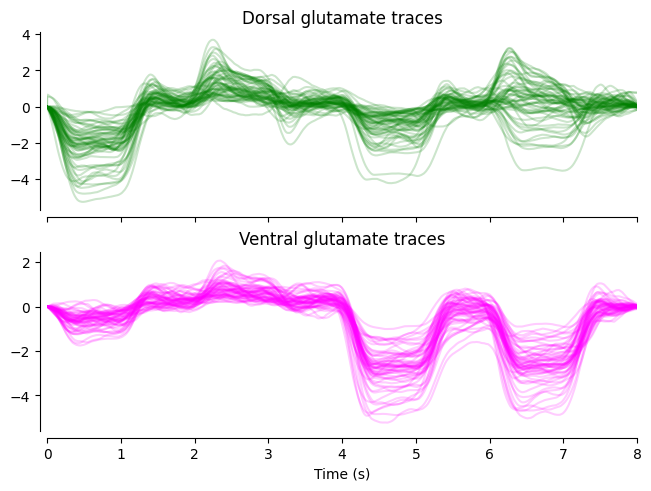

In [51]:
fig, axs = plt.subplots(2, 1, sharex=True, layout="constrained")

time = np.arange(0, 8, step=fs)

for i in range(60):
    axs[0].plot(time, trace_collection[i, :], color="g", alpha=0.2)
    axs[1].plot(time, trace_collection[i+60, :], color="magenta", alpha=0.2)

axs[0].set_title("Dorsal glutamate traces")
axs[1].set_title("Ventral glutamate traces")

axs[1].set_xlim(0, 8)
axs[1].set_xlabel("Time (s)")

sns.despine(offset=5)
plt.show()

In [53]:
# Divide the trace collection into center and surround for each color
green_center = trace_collection[:, 0:int(2/fs)]
uv_center = trace_collection[:, int(4/fs):int(6/fs)]

green_surround = trace_collection[:, int(2/fs):int(4/fs)]
uv_surround = trace_collection[:, int(6/fs):int(8/fs)]

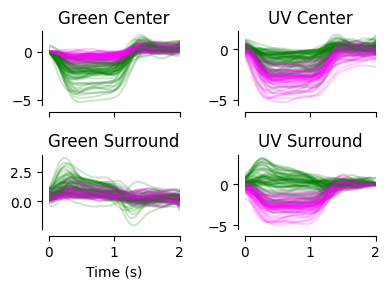

In [82]:
# Plot some of the center traces
fig, ax = plt.subplots(2, 2, figsize=(4, 3), sharex=True)

time = np.arange(0, 2, step=fs)

for i in range(60):
    ax[0, 0].plot(time, green_center[i, :], color="g", alpha=0.2)
    ax[0, 1].plot(time, uv_center[i, :], color="g", alpha=0.2)
    ax[1, 0].plot(time, green_surround[i, :], color="g", alpha=0.2)
    ax[1, 1].plot(time, uv_surround[i, :], color="g", alpha=0.2)

    ax[0, 0].plot(time, green_center[i+60, :], color="magenta", alpha=0.2)
    ax[0, 1].plot(time, uv_center[i+60, :], color="magenta", alpha=0.2)
    ax[1, 0].plot(time, green_surround[i+60, :], color="magenta", alpha=0.2)
    ax[1, 1].plot(time, uv_surround[i+60, :], color="magenta", alpha=0.2)

ax[0, 0].set_title("Green Center")
ax[0, 1].set_title("UV Center")
ax[1, 0].set_title("Green Surround")
ax[1, 1].set_title("UV Surround")

ax[0, 0].set_xlim(0, 2)
ax[1, 0].set_xlabel("Time (s)")

sns.despine(offset=5)
plt.tight_layout()
plt.show()

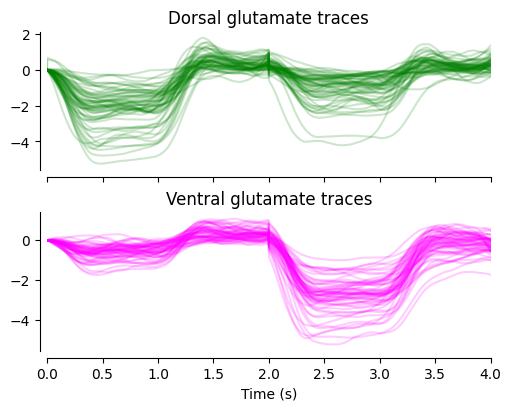

In [85]:
all_center_traces = np.concatenate((green_center, uv_center), axis=1)

fig, axs = plt.subplots(2, 1, figsize=(5, 4), sharex=True, layout="constrained")

time = np.arange(0, 4, step=fs)

for i in range(60):
    axs[0].plot(time, all_center_traces[i, :], color="g", alpha=0.2)
    axs[1].plot(time, all_center_traces[i+60, :], color="magenta", alpha=0.2)

axs[0].set_title("Dorsal glutamate traces")
axs[1].set_title("Ventral glutamate traces")

axs[1].set_xlim(0, 4)
axs[1].set_xlabel("Time (s)")

sns.despine(offset=5)
plt.show()

In [86]:
with open("../../data/120_center_responses.pkl", "wb") as f:
    pickle.dump(all_center_traces, f)